## Notes

Diminuer le pas, va marcher mais trop long
gradient amorti, gradient à pas optimal

c1 = 10^-4, c2 = 0.9

Style de rendu ?

Questions
- q6 manque une composante vecteur c, alpha non négligeable ?
- q7 max coût ou profit ?
- q8 norme non différentiable en 0 ?
- calculer gradient à la main ou autograd ? besoin pour scipy ? problème décompose vecteur z...
- deux algorithmes à trouver... : newton avec pénalisation (mais pas dans le cours ?) et gradient proximal ?
- vérifier avec scipy (ou à utiliser ?), quel choix de méthode ? calcul gradient des fonctions & des coûts ?
- scipy à la fin : production négative : rajouter des contraintes
- résultat pas entier : moitié de croissant ? où arrondir ?
- résultat différent : mauvaise valeur de alpha... ? à quoi s'attendre ?
- grande variabilité selon la valeur de alpha ? bizarre première méthode... ou problème scipy slsqp sans gradient spécifié (important) ?


In [1]:
import numpy as np
from scipy import optimize
np.set_printoptions(suppress=True)

## 1. Etude du problème d'optimisation

### Question 1

Le coût (2) correspond au profit de la boulangerie : $\sum(produits)$ $-$ $\sum(coûts)$

- $c^T r$ est le coût d'achat des matières premières
- $v^T q$ est le montant rapporté par la vente d'une quantité de produits $q$ (tout ce qui a été produit)
- $v^T d$ est le montant rapporté par la vente d'une quantité de produits $d$ (tout ce qui a été demandé)

Ainsi, le terme $\min\{q,d\}$ correspond à la quantité effectivement vendue : le minimum entre ce qui a été produit ou demandé. En effet, le facteur limitant des gains dépend si la demande est supérieure à la production ou si la production est supérieure à la demande (dans le cas d'économies d'échelle par exemple, cela peut être rentable).


### Question 2

Ce terme avec un $\min$ n'est pas un opérateur linéaire, il n'est donc peut-être pas différentiable et ne permet pas d'appliquer les méthodes du cours les plus efficaces.

/!\ pourquoi "opérateur linéaire" ?

### Question 3

Cette formule fait penser à la statistique de Maxwell-Boltzmann.

Soit $i \in [|1, p|]$.

Cas 1 : $q_i > d_i$. Montrons que $h_i \approx d_i$.

$\exp(-\alpha q_i) << \exp(-\alpha d_i)$ et $q_i \exp(-\alpha q_i)$ est toujours petit devant $d_i \exp(-\alpha d_i)$ car $\alpha >> 1$, ce qui permet de simplifier et d'obtenir le résultat.

Cas 2 : $q_i < d_i$. On procède de manière similaire par symétrie

On a donc maintenant une fonction convexe et surtout différentiable ce qui permet de se placer dans un cadre où l'on dispose de plus de résultats.

### Question 4

On suppose que $d$ est fixé. On pose :

- $z = (q, r)$ (de taille $n=p + m$)
- $f(z) = f(q, r) = c^T r - v^T h(q, d)$, à valeurs dans $\mathbb{R}$
- $c(z) = c(q, r) = A q - r$ ($m$ contraintes)

## 2. Etude et résolution numérique

### Question 5

Puisque la fonction $f$ est deux-fois différentiable, on peut utiliser la méthode la plus efficace pour l'optimisation différentiable, c'est-à-dire la méthode de Newton. Toutefois, il faut prendre en compte les contraintes inégalités. On peut donc penser à une optimisation avec pénalités.

Une autre approche serait les algorithmes d'optimisiation différentiable sous contraintes, comme celui Uzawa ou d'Arrow-Hurwicz (les contraintes sont linéaires)

### Question 6

Il est surprenant que $1$ ne soit pas négligeable devant $\alpha$...

In [28]:

def q6(alpha=0.1):
    c = 1e-3*np.array([30.,1.,4.,1., 1.])
    v = np.array([0.9, 1.5, 1.1])
    d = np.array([400., 67., 33.])
    A = np.array([[3.5,2.,1.],[250.,80., 25.],[0., 8., 3.],[0., 40., 10.], [0., 8.5, 0.]])
    n = len(c)+len(d)
    return n, alpha, c, v, d, A

#n, alpha, c, v, d, A = q6()
x0 = np.zeros(n)
print(n)

8


In [29]:
def fun_h(q, d, alpha=alpha):
    return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))

print(fun_h(np.array([1.,2.,3.]), d))

def fun_f(z, d=d, A=A, c=c, v=v, alpha=alpha):
    q = z[:len(d)]
    r = z[len(d):]
    return c.T @ r - v.T @ fun_h(q, d, alpha)

ztest = np.array([1.,2.,3.,4.,5.,6.,7.,8.])
print(fun_f(ztest))

def fun_c(z, A=A):
    q = z[:len(d)]
    r = z[len(d):]
    return A @ q - r

print(c)

[1. 2. 3.]
-7.0360000000000005
[0.03  0.001 0.004 0.001 0.001]


In [30]:
ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_c(x)}
res = optimize . minimize(fun_f, x0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})

print(res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -329.68039086503614
            Iterations: 66
            Function evaluations: 642
            Gradient evaluations: 66
[   385.31737824     67.23588632     33.41898694   1516.50158344
 102543.69013996    638.14405141   3023.62532236    571.50503375]


<ipython-input-29-a1a4604c4267>:2: RuntimeWarning: overflow encountered in exp
  return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))
<ipython-input-29-a1a4604c4267>:2: RuntimeWarning: invalid value encountered in true_divide
  return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))


<ipython-input-45-5c11035186b9>:12: RuntimeWarning: overflow encountered in exp
  return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))
<ipython-input-45-5c11035186b9>:12: RuntimeWarning: invalid value encountered in true_divide
  return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))


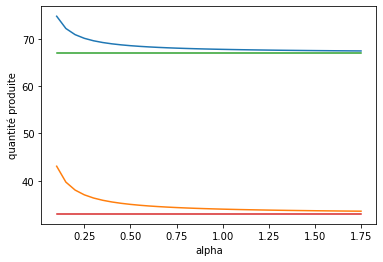

In [45]:
# avec différents alpha

import matplotlib.pyplot as plt

baguettes_list, chocolats_list, croissants_list = [], [], []
alphas = np.arange(0.1, 1.8, 0.05)

for a in alphas:
    n, alpha, c, v, d, A = q6(a)
    
    def fun_h(q, d, alpha=alpha):
        return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))


    def fun_f(z, d=d, A=A, c=c, v=v, alpha=alpha):
        q = z[:len(d)]
        r = z[len(d):]
        return c.T @ r - v.T @ fun_h(q, d, alpha)

    def fun_c(z, A=A):
        q = z[:len(d)]
        r = z[len(d):]
        return A @ q - r

    ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_c(x)}
    res = optimize . minimize(fun_f, x0, method= 'SLSQP' ,
    constraints= [ineq_cons], options={ 'disp' : False, 'maxiter': 10000})
    
    baguettes, chocolats, croissants = res.x[:3]
    baguettes_list.append(baguettes)
    chocolats_list.append(chocolats)
    croissants_list.append(croissants)

plt.figure()
#plt.plot(alphas, baguettes_list)
plt.plot(alphas, chocolats_list)
plt.plot(alphas, croissants_list)
#plt.plot(alphas, 400*np.ones(len(alphas)))
plt.plot(alphas, 67*np.ones(len(alphas)))
plt.plot(alphas, 33*np.ones(len(alphas)))
plt.xlabel("alpha")
plt.ylabel("quantité produite")
plt.show()


Légère surproduction : très étonnant, économie d'échelle ? pas tout à fait comme intuition : plutôt moins ou = à la demande mais pas plus...


Comparer aussi la valeur du profit en lui-même... ?

### Question 7

a. Problème d'optimisation.

On calcule l'espérance de l'opposé du profit : $E(z)=\pi_1 f_1(z)+\pi_2 f_2(z)+\pi_3 f_3(z)$ où $f_i(z)= c^T r - v^T h(q, d^i)$

On minimise donc cette quantité $E(z)$ avec les mêmes contraintes.



In [132]:
def q7():
    d1 = np.array([400., 67., 33.])
    d2 = np.array([500., 80., 53.])
    d3 = np.array([300., 60., 43.])
    p1 = 0.5
    p2 = 0.3
    p3 = 0.2
    return d1, p1, d2, p2, d3, p3

ps = q7()


In [133]:
def fun_E(z, ps=ps):
    d1, p1, d2, p2, d3, p3 = ps
    return p1*fun_f(z, d1)+p2*fun_f(z, d2)+p3*fun_f(z, d3)

In [134]:
ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_c(x)}
res = optimize . minimize(fun_E, x0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})

print(res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -332.85639212736544
            Iterations: 72
            Function evaluations: 665
            Gradient evaluations: 72
[   406.7080966      79.35835244     55.24061306   1637.43565605
 109406.70767265    800.58865869   3726.74022815    674.54599573]


Produit un peu plus pour couvrir la variabilité si plus de demande car proba plus de demande plus importante que demande plus faible ?

Comparer aussi la valeur du profit en lui-même...

### Question 8

a. On suppose que $r$ et $d$ sont fixés. On a toujours le terme de revenus $v^T h(q,d)$. Le premier terme correspond à $(q-d)^T(q-d)$. $q-d$ est la différence entre ce qui est produit et ce qui est demandé. Cela correspond donc au coût induit par le gaspillage si $q>d$, ou le coût de la non-satisfaction de la demande si $d>q$d. On cherche donc bien à minimiser ce coût...

b. 

In [138]:
ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_c(x)}
res = optimize . minimize(fun_E, x0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})

y = res.x
#print(y)
r = y[len(d):]
#print(r)

def fun_g(q, d=ps[4], v=v):
    return (q-d).T @ (q-d) - v.T @ fun_h(q, d) # attention norme au carré

def fun_cb(q, r=r, d=ps[4]):
    return fun_c(np.hstack((q, r)))

y0 = np.zeros(len(d))
#print(y0)

ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_cb(x)}
res = optimize . minimize(fun_g, y0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})
print(res.x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -332.85639212736544
            Iterations: 72
            Function evaluations: 665
            Gradient evaluations: 72
Optimization terminated successfully    (Exit mode 0)
            Current function value: -407.55865453752693
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 7
[300.2195123   60.36145378  43.26755944]


Moins de gaspillage ? Adapté Très proche de la demande $d^3$


Comparer aussi la valeur du profit en lui-même...

## 3. Etude du problème non-régularisé

### Question 9

Méthode de gradient proximale (optimisation non-différentiable ?) (cf Traitement du Signal ?)

### Question 10

In [139]:
def fun_hb(q, d, alpha=alpha):
    return np.minimum(q,d)

print(fun_hb(np.array([1.,2.,3.]), d))

def fun_fb(z, d=d, A=A, c=c, v=v, alpha=alpha):
    q = z[:len(d)]
    r = z[len(d):]
    return c.T @ r - v.T @ fun_hb(q, d, alpha)

def fun_cb(z, A=A):
    q = z[:len(d)]
    r = z[len(d):]
    return np.hstack((A @ q - r,-q))

ztest = np.array([1.,2.,3.,4.,5.,6.,7.,8.])
print(fun_fb(ztest))

[1. 2. 3.]
-7.0360000000000005


In [140]:
ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_cb(x)}
res = optimize . minimize(fun_fb, x0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})
print(res.x)

# résultat fantasiste : méthode de scipy pas adaptée au problème ? profit positif car opposé du résultat...
# SLSQP pourtant OK pour non linéaire ? problème gradient ?
# problème alpha ?

# pas possible production négative ?? rajout d'une contrainte : fun_cb

Optimization terminated successfully    (Exit mode 0)
            Current function value: -222.3135315308291
            Iterations: 59
            Function evaluations: 615
            Gradient evaluations: 59
[   399.98099087     80.88927743     33.0000028    2175.50014173
 107291.38998093  12510.8926088   43039.11616086   8830.27942088]


Résultat assez différents (quantifier ?) : normal ou non ?